In [2]:
import os
import sys
import urllib
from collections import defaultdict

import numpy as np

from astropy import units as u
from astropy import table
from astropy.coordinates import SkyCoord, EarthLocation, get_sun
from astropy.time import Time
from astropy.io import fits

import astroquery

from importlib import reload

%matplotlib inline
from matplotlib import style, pyplot as plt

# Initial setup 

In [3]:
working_dir = os.path.abspath('..')

%cd ../../saga
sagadir = !pwd
sagadir = sagadir[0]
!python setup.py build
%cd $working_dir

/Users/erik/projects/saga/saga
running build
running build_py
copying SAGA/targets/target_selection.py -> build/lib/SAGA/targets
/Users/erik/projects/saga/erik


In [4]:
sagalibdir = os.path.join(sagadir, 'build/lib')
print('Adding', sagalibdir, 'to the python path')
sys.path.insert(0, sagalibdir)

import SAGA as saga
from SAGA.database import external 

Adding /Users/erik/projects/saga/saga/build/lib to the python path


In [5]:
saga_database = saga.Database(os.path.join(os.environ['HOME'],'Dropbox/SAGA/'))

saga_host_catalog = saga.HostCatalog(saga_database)
saga_object_catalog = saga.ObjectCatalog(saga_database)

In [6]:
hosts_to_load = 'aat_2018'
host_id_label = 'ID_STR'
targethosts = saga_host_catalog.load(hosts_to_load)
targethosts[host_id_label] = saga_host_catalog.resolve_id(hosts_to_load, 'string')

In [7]:
obs_start_date = Time('2018-6-10')

# Downloading of catalogs

In [ ]:
sdsshosts = saga_host_catalog.load('flag0')
sdsshosts[host_id_label] = saga_host_catalog.resolve_id('flag0', 'string')
hosts_todl = targethosts[np.in1d(targethosts[host_id_label], sdsshosts[host_id_label])]


failed = external.download_catalogs_for_hosts(hosts_todl, external.SdssQuery, 
                                              saga_database.sdss_file_path_pattern, 
                                              overwrite=False, 
                                              host_id_label=host_id_label)
print('# failed =', np.count_nonzero(failed))

In [ ]:
deshosts = saga_host_catalog.load('has_des')
deshosts[host_id_label] = saga_host_catalog.resolve_id('has_des', 'string')
hosts_todl = targethosts[np.in1d(targethosts[host_id_label], deshosts[host_id_label])]

failed = external.download_catalogs_for_hosts(hosts_todl, external.DesQuery, 
                                              saga_database.des_file_path_pattern, 
                                              overwrite=False, 
                                              host_id_label=host_id_label)
print('# failed =', np.count_nonzero(failed))

In [ ]:
decalshosts = saga_host_catalog.load('has_decals')
decalshosts[host_id_label] = saga_host_catalog.resolve_id('has_decals', 'string')
hosts_todl = targethosts[np.in1d(targethosts[host_id_label], decalshosts[host_id_label])]

failed = external.download_catalogs_for_hosts(hosts_todl, external.DecalsPrebuilt, 
                                              saga_database.decals_file_path_pattern, 
                                              overwrite=False, 
                                              host_id_label=host_id_label)
print('# failed =', np.count_nonzero(failed))

## Base catalogs if needed

In [ ]:
saga_object_catalog.build_and_write_to_database('aat_2018', overwrite=False)

# Generate AAT-style target catalogs 

In [8]:
saga_database['manual_targets_aat2018a'].local.path = 'aat_targets_jun2018/manual_targets.csv'

saga_targets = saga.TargetSelection(saga_database, 
                                    manual_selected_objids='manual_targets_aat2018a',
                                    gmm_parameters={'sdss':'gmm_parameters_no_outlier', 
                                                    'des': 'gmm_parameters_no_outlier_no_u'}, 
                                    version=2)

In [163]:
def get_gaia_guidestars(hostname, magrng=(12.5, 14),
                        matchmagrng=(16, 17), d_matchmag=1, matchtol0=20*u.arcsec,
                        verbose=True, neighbor_cut=5*u.arcsec):
    """
    `magrng` is the range of magnitudes to actually select on.  It's ~r-band, based on the
    Evans et al. 2018 r-to-G conversion
    """
    print = __builtin__.print
    if not verbose:
        print = lambda *args, **kwargs:None
        
    host = saga_host_catalog.load_single(hostname)
    obj_cat = saga_object_catalog.load(hostname)[0]
    omag = obj_cat['r_mag']
    gaia_cat = table.Table.read('external_catalogs/astrometric/{}_gaia.ecsv'.format(hostname))
    gaia_sc = SkyCoord(gaia_cat['ra'], gaia_cat['dec'])
    gmag = gaia_cat['phot_g_mean_mag']
    
    omsk = (matchmagrng[0]<omag)&(omag<matchmagrng[1])
    gmsk = ((matchmagrng[0]-d_matchmag)<gmag)&(gmag<(matchmagrng[1]+d_matchmag))
    oscmsk = obj_cat['coord'][omsk]
    gscmsk = gaia_sc[gmsk]
    
    idx, d2d, _ = oscmsk.match_to_catalog_sky(gscmsk)
    sepmsk = d2d < matchtol0
    
    dra = (oscmsk[sepmsk].ra - gscmsk[idx][sepmsk].ra).to(u.arcsec)
    ddec = (oscmsk[sepmsk].dec - gscmsk[idx][sepmsk].dec).to(u.arcsec)
    offset = np.mean(dra), np.mean(ddec)
    
    print("Object catalog to Gaia offset:", offset)
    
    #this polynomial is from Evans et al. 2018 for the G to r conversion
    Gmr_coeffs = (-0.1856, 0.1579, 0.02738, -0.0550)
    Gmr = np.polyval(Gmr_coeffs[::-1], gaia_cat['bp_rp'])
    gaia_cat['g_as_r_mag'] = gmag - Gmr
    
    gmsk = (magrng[0] < gaia_cat['g_as_r_mag'])&(gaia_cat['g_as_r_mag'] < magrng[1])
    gstars = gaia_cat[gmsk]
    print('Found', len(gstars), 'Gaia guide stars')
    
    if neighbor_cut is not None:
        possible_neighbor_stars = gaia_cat[gaia_cat['g_as_r_mag'] < magrng[1]+1]
        nsc = SkyCoord(possible_neighbor_stars['ra'], possible_neighbor_stars['dec'])
        gsc = SkyCoord(gstars['ra'], gstars['dec'])
        idx, d2d, _ = gsc.match_to_catalog_sky(nsc, 2)
        neighbor_present = d2d < neighbor_cut
        print(np.sum(neighbor_present), 'Have a brightish neighbor.  Removing them.')
        gstars = gstars[~neighbor_present]

    tab = table.Table({
        'TargetName': gstars['source_id'],
        'RA': (u.Quantity(gstars['ra']) + offset[0]),
        'Dec': (u.Quantity(gstars['dec']) + offset[1]),
        'TargetType': np.repeat('F', len(gstars)),
        'Priority': np.repeat(9, len(gstars)),
        'Magnitude':gstars['g_as_r_mag'],
        '0': np.repeat(0, len(gstars)),
        'Notes': np.repeat('guide_gaia', len(gstars)),
    })
    tab.meta['dra'] = dra
    tab.meta['ddec'] = ddec
    tab.meta['offset'] = offset
    tab.meta['gstarcat'] = gstars
    return tab

In [10]:
def get_sdss_guidestars(hostname):
    host = saga_host_catalog.load_single(hostname)
    obj_cat = saga_object_catalog.load(hostname)[0]
    r = obj_cat['r_mag']
    msk = (12.5<r)&(r<14)&~obj_cat['is_galaxy']&(obj_cat['RHOST_ARCM']>15)
    starcat = obj_cat[msk]
    
    return table.Table({
        'TargetName': starcat['OBJID'],
        'RA': starcat['RA'],
        'Dec': starcat['DEC'],
        'TargetType': np.repeat('F', len(starcat)),
        'Priority': np.repeat(9, len(starcat)),
        'Magnitude': starcat['r_mag'],
        '0': np.repeat(0, len(starcat)),
        'Notes': np.repeat('guide', len(starcat)),
    })

In [45]:
from astropy.coordinates import Angle

def write_fld_file(target_catalog, host, obstime, fn):
    hostname = host[host_id_label]
    target_catalog.write(fn,
                         delimiter=' ',
                         quotechar='"',
                         format='ascii.fast_commented_header',
                         overwrite=True,
                         formats={
                            'RA': lambda x: Angle(x, 'deg').wrap_at(360*u.deg).to_string('hr', sep=' ', precision=2), # pylint: disable=E1101
                            'Dec': lambda x: Angle(x, 'deg').to_string('deg', sep=' ', precision=2),
                            'Magnitude': '%.2f',
                         })
    with open(fn) as fh:
        content = fh.read()
    with open(fn, 'w') as fh:
        fh.write('LABEL ' + hostname + ' master catalog\n')
        fh.write('UTDATE  {yr} {mo:02} {day:02}\n'.format(yr=obstime.datetime.year,
                                                        mo=obstime.datetime.month,
                                                        day=obstime.datetime.day))
        censtr = host['coord'].to_string('hmsdms', sep=' ', precision=2, alwayssign=True)
        fh.write('CENTRE  ' + censtr + '\n')
        fh.write('EQUINOX J2000.0\n')
        fh.write('# End of Header\n\n')
        fh.write(content.replace('"', ''))

In [11]:
def make_decals_viewer_cutouts(table, survey='sdss', ncols=3, zoom=15, size=120, namecol=None, dhtml=True):
    """
    Zoom of 15 is ~1"/pixel, so ~2' across with defaults
    """
    template_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra={ra:.7}&dec={dec:.7}&zoom={zoom}&layer={layer}&size={size}'
    
    raname = decname = None
    for cnm in table.colnames:
        if cnm.lower()=='ra':
            raname = cnm
        elif cnm.lower()=='dec':
            decname = cnm
    
    entries = []
    for row in table:
        imgurl = template_url.format(ra=row[raname], dec=row[decname], layer=survey, size=size, zoom=zoom)
        viewurl = 'http://legacysurvey.org/viewer?ra={}&dec={}'.format(row[raname], row[decname])
        
        namestr = '' if namecol is None else (str(row[namecol]) + '<br>')
        entries.append('{}<a href="{}"><img src="{}"></a>'.format(namestr, viewurl, imgurl))
        
    entryrows = [[]]
    while entries:
        entry = entries.pop(0)
        if len(entryrows[-1]) >= ncols:
            entryrows.append([])
        entryrows[-1].append(entry)
    entryrows[-1].extend(['']*(ncols-len(entryrows[-1])))
    
    tabrows = ['<td>{}</td>'.format('</td><td>'.join(erow)) for erow in entryrows]

    htmlstr = """
    <table>
    <tr>{}</tr>
    </table>
    """.format('</tr>\n<tr>'.join(tabrows))

    if dhtml:
        from IPython import display
        return display.HTML(htmlstr)
    else:
        return htmlstr

# Night 1

In [12]:
import aat

## nsa3469

In [99]:
for host in targethosts[targethosts['NSAID'] == 3469]:
    hostname = host[host_id_label]
    print(hostname)
    tcat = saga_targets.build_target_catalogs(hostname, return_as='list').pop()
    acat = saga.targets.prepare_aat_catalog(tcat)
    
    guidestars = get_sdss_guidestars(hostname)
    writecat = table.vstack([acat, guidestars])
    
    fnout = 'aat_targets_jun2018/{}_master.fld'.format(hostname)
    print('Writing', fnout)
    writecat['Notes'] = [n.title() for n in writecat['Notes']]
    write_fld_file(writecat, host, obs_start_date, fnout)

nsa3469
# of flux stars = 143
# of sky fibers = 100
# of Priority=1 targets = 561
# of Priority=2 targets = 9
# of Priority=3 targets = 16
# of Priority=4 targets = 50
# of Priority=5 targets = 511
# of Priority=6 targets = 144
# of Priority=7 targets = 4
# of Priority=8 targets = 0
# of Priority=9 targets = 243


/Users/erik/projects/saga/saga/build/lib/SAGA/objects/object_catalog.py:54: RuntimeWarning: invalid value encountered in subtract
  table[color] = table['{}_mag'.format(color[0])] - table['{}_mag'.format(color[1])]
/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


Writing aat_targets_jun2018/nsa3469_master.fld


In [27]:
aat.subsample_from_master_fld('aat_targets_jun2018/nsa3469_master.fld', 
                              'aat_targets_jun2018/nsa3469_1.fld',
                             {1:0,2:np.inf,3:np.inf,4:np.inf,
                              5:np.inf,6:np.inf,7:np.inf,8:np.inf,9:np.inf},
                              nflux=5)

Total remaining in each priority (5 fluxes, 141 guides, and 100 skies not included):
{1: 561, 2: 9, 3: 16, 4: 50, 5: 511, 6: 144, 7: 4, 8: 0, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: None, 9: None}%


Note: was not able to inspect the skies *before* observing.  Below is to know which might be a problem

In [98]:
make_decals_viewer_cutouts(acat[acat['Notes']=='sky'], survey='decals-dr5', ncols=6, 
                           zoom=16, namecol='TargetName')

0,1,2,3,4,5
6,7,8,9,10,11
12,13,14,15,16,17
18,19,20,21,22,23
24,25,26,27,28,29
30,31,32,33,34,35
36,37,38,39,40,41
42,43,44,45,46,47
48,49,50,51,52,53
54,55,56,57,58,59
60,61,62,63,64,65


7, 22, 81, and 76 remove for future.  None used in true config.

## nsa145729

In [102]:
for host in targethosts[targethosts['NSAID'] == 145729]:
    hostname = host[host_id_label]
    print(hostname)
    tcat = saga_targets.build_target_catalogs(hostname, return_as='list').pop()
    acat = saga.targets.prepare_aat_catalog(tcat)
    #acat = saga.targets.prepare_aat_catalog(tcat, 'aat_targets_jun2018/{}.cat'.format(hostname))
    
    guidestars = get_sdss_guidestars(hostname)
    writecat = table.vstack([acat, guidestars])
    
    fnout = 'aat_targets_jun2018/{}_master.fld'.format(hostname)
    print('Writing', fnout)
    writecat['Notes'] = [n.title() for n in writecat['Notes']]
    write_fld_file(writecat, host, obs_start_date, fnout)

nsa145729
# of flux stars = 318
# of sky fibers = 100
# of Priority=1 targets = 536
# of Priority=2 targets = 16
# of Priority=3 targets = 14
# of Priority=4 targets = 50
# of Priority=5 targets = 259
# of Priority=6 targets = 105
# of Priority=7 targets = 3
# of Priority=8 targets = 2
# of Priority=9 targets = 418
Writing aat_targets_jun2018/nsa145729_master.fld


/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [83]:
aat.subsample_from_master_fld('aat_targets_jun2018/nsa145729_master.fld', 
                              'aat_targets_jun2018/nsa145729_1.fld',
                             {1:np.inf,2:np.inf,3:np.inf,4:np.inf,
                              5:np.inf,6:np.inf,7:np.inf,8:np.inf,9:np.inf},
                              nflux=5)

Total remaining in each priority (5 fluxes, 196 guides, and 100 skies not included):
{1: 536, 2: 16, 3: 14, 4: 50, 5: 259, 6: 105, 7: 3, 8: 2, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: 100.0, 9: None}%


In [251]:
aat.imagelist_fld_targets('aat_targets_jun2018/{}_1.fld'.format(hostname))

'name ra dec\n1237655693551797043 224.28362499999997 -1.0167166666666667\n1237648702984356321 224.20654166666662 -1.0672416666666666\n1237655499210425196 224.52899999999997 -1.6290027777777778\n1237655499210424420 224.49804166666664 -1.5100833333333332\n1237648703521489922 224.88395833333328 -0.6706027777777778\n1237648703521489868 224.8677083333333 -0.6261666666666666\n1237655692478251284 224.83333333333331 -1.8719555555555556\n1237655693015253946 225.08166666666665 -1.3044916666666666\n3255080000000003744 225.0220833333333 -0.9379694444444444\n1237648702984880207 225.44270833333331 -1.098197222222222\n1237648703521554976 225.01366666666664 -0.73385\n1237648702984159385 223.8535833333333 -1.0734861111111111\n3283850000000001411 224.38399999999996 -0.5618666666666667\n3269470000000001139 224.9160833333333 -0.8147527777777778\n3298240000000003919 224.08645833333333 -0.23843333333333333\n1237648703521685692 225.35679166666665 -0.79815\n1237648704058425599 224.98370833333328 -0.411225\n41

In [103]:
make_decals_viewer_cutouts(acat[acat['Notes']=='sky'], survey='decals-dr5', ncols=6, 
                           zoom=16, namecol='TargetName')

0,1,2,3,4,5
6,7,8,9,10,11
12,13,14,15,16,17
18,19,20,21,22,23
24,25,26,27,28,29
30,31,32,33,34,35
36,37,38,39,40,41
42,43,44,45,46,47
48,49,50,51,52,53
54,55,56,57,58,59
60,61,62,63,64,65


If future obs come up, removing 93, 76, 43, 15, 29.  None on actual observed config.

## pgc66318

In [293]:
for host in targethosts[targethosts['PGC'] == 66318]:
    hostname = host[host_id_label]
    print(hostname)
    tcat = saga_targets.build_target_catalogs(hostname, return_as='list').pop()
    acat = saga.targets.prepare_aat_catalog(tcat)
    
    guidestars = get_gaia_guidestars(hostname)
    writecat = table.vstack([acat, guidestars])
    
    fnout = 'aat_targets_jun2018/{}_master.fld'.format(hostname)
    print('Writing', fnout)
    writecat['Notes'] = [n.title() for n in writecat['Notes']]
    write_fld_file(writecat, host, obs_start_date, fnout)

pgc66318
# of flux stars = 427
# of sky fibers = 100
# of Priority=1 targets = 203
# of Priority=2 targets = 80
# of Priority=3 targets = 105
# of Priority=4 targets = 50
# of Priority=5 targets = 181
# of Priority=6 targets = 86
# of Priority=7 targets = 16
# of Priority=8 targets = 30
# of Priority=9 targets = 527
Object catalog to Gaia offset: (<Angle -0.11870022 arcsec>, <Angle 0.14161216 arcsec>)
Writing aat_targets_jun2018/pgc66318_master.fld


Visually check guide stars and sky fibers.  Remove any skies that are bad.

In [324]:
make_decals_viewer_cutouts(guidestars[np.random.permutation(len(guidestars))[:24]], survey='unwise-w1w2',ncols=6,namecol='TargetName')

6478545578574218240,6479620419909929472,6478716552631970048,6478928380419347328,6478908211252990720,6478052997365124608
6478982668806113024,6479563176585618816,6478787917808680320,6478859347408457216,6478791010185102336,6478918656613442560
6478642777977847040,6477297323639461248,6478744212221437696,6479556820034021504,6478683464204298240,6478943842301621888
6478674530672328192,6479277814662814464,6478594197603927808,6478602306502168448,6478861069691826176,6479695049261674624


In [323]:
make_decals_viewer_cutouts(acat[acat['Notes']=='sky'], survey='unwise-w1w2', ncols=6, 
                           zoom=16, namecol='TargetName')

0,1,2,3,4,5
6,7,8,9,10,11
12,13,14,15,16,17
18,19,20,21,22,23
24,25,26,27,28,29
30,31,32,33,34,35
36,37,38,39,40,41
42,43,44,45,46,47
48,49,50,51,52,53
54,55,56,57,58,59
60,61,62,63,64,65


Removing 0, 8, 15, 37, 46, 53, 62, 63, 67, 70, 84, 99 from the master catalog

In [89]:
aat.subsample_from_master_fld('aat_targets_jun2018/{}_master.fld'.format(hostname), 
                              'aat_targets_jun2018/{}_1.fld'.format(hostname),
                             {1:np.inf,2:np.inf,3:np.inf,4:np.inf,
                              5:np.inf,6:np.inf,7:np.inf,8:np.inf,9:np.inf},
                              nflux=5, nguides=100)

Total remaining in each priority (5 fluxes, 100 guides, and 100 skies not included):
{1: 203, 2: 80, 3: 105, 4: 50, 5: 181, 6: 86, 7: 16, 8: 30, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: 100.0, 9: None}%


Note that `aat_targets_jun2018/pgc66318_1.fld` ended up getting made *before* the sky-fiber cleanup due to time constraints.  But it appears that the fibers assigned to the actual observations are clear?

## pgc66934

In [46]:
for host in targethosts[targethosts['PGC'] == 66934]:
    hostname = host[host_id_label]
    print(hostname)
    tcat = saga_targets.build_target_catalogs(hostname, return_as='list').pop()
    acat = saga.targets.prepare_aat_catalog(tcat)
    
    guidestars = get_gaia_guidestars(hostname)
    writecat = table.vstack([acat, guidestars])
    
    fnout = 'aat_targets_jun2018/{}_master.fld'.format(hostname)
    print('Writing', fnout)
    writecat['Notes'] = [n.title() for n in writecat['Notes']]
    write_fld_file(writecat, host, obs_start_date, fnout)

pgc66934
# of flux stars = 268
# of sky fibers = 100
# of Priority=1 targets = 241
# of Priority=2 targets = 135
# of Priority=3 targets = 94
# of Priority=4 targets = 50
# of Priority=5 targets = 170
# of Priority=6 targets = 65
# of Priority=7 targets = 18
# of Priority=8 targets = 20
# of Priority=9 targets = 368
Object catalog to Gaia offset: (<Angle -0.12299029 arcsec>, <Angle 0.1454588 arcsec>)
Writing aat_targets_jun2018/pgc66934_master.fld


In [60]:
make_decals_viewer_cutouts(guidestars[np.random.permutation(len(guidestars))[:24]], 
                           survey='unwise-w1w2',ncols=6,namecol='TargetName')

6577860306382962944,6577596011275249664,6576368990658589184,6577602711424241664,6576324116840171136,6576310544743577472
6576359438651334272,6577792274100915968,6576289860181064064,6577860065864787456,6576090539338695808,6576271718239143936
6577644664664848384,6577863428822858112,6576256909191882752,6577523409148020480,6576356999109865856,6577525432076225024
6576063807462249728,6577569519916995200,6577535774357467776,6576065800326958464,6577605666361732352,6576080093978198016


6576299790145393152 is problematic because it's right next to a much brighter star.  Will remove.

In [61]:
make_decals_viewer_cutouts(acat[acat['Notes']=='sky'], survey='unwise-w1w2', ncols=6, 
                           zoom=16, namecol='TargetName')

0,1,2,3,4,5
6,7,8,9,10,11
12,13,14,15,16,17
18,19,20,21,22,23
24,25,26,27,28,29
30,31,32,33,34,35
36,37,38,39,40,41
42,43,44,45,46,47
48,49,50,51,52,53
54,55,56,57,58,59
60,61,62,63,64,65


Removing 13, 16, 26, 28, 57, 59

In [62]:
aat.subsample_from_master_fld('aat_targets_jun2018/{}_master.fld'.format(hostname), 
                              'aat_targets_jun2018/{}_1.fld'.format(hostname),
                             {1:np.inf,2:np.inf,3:np.inf,4:np.inf,
                              5:np.inf,6:np.inf,7:np.inf,8:np.inf,9:np.inf},
                              nflux=5, nguides=100)

Total remaining in each priority (5 fluxes, 100 guides, and 94 skies not included):
{1: 241, 2: 135, 3: 94, 4: 50, 5: 170, 6: 65, 7: 18, 8: 20, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: 100.0, 9: None}%


## PGC 2052 

In [164]:
for host in targethosts[targethosts['PGC'] == 2052]:
    hostname = host[host_id_label]
    print(hostname)
    tcat = saga_targets.build_target_catalogs(hostname, return_as='list').pop()
    acat = saga.targets.prepare_aat_catalog(tcat)
    
    guidestars = get_gaia_guidestars(hostname)
    writecat = table.vstack([acat, guidestars])
    
    fnout = 'aat_targets_jun2018/{}_master.fld'.format(hostname)
    print('Writing', fnout)
    writecat['Notes'] = [n.title() for n in writecat['Notes']]
    write_fld_file(writecat, host, obs_start_date, fnout)

pgc2052
# of flux stars = 70
# of sky fibers = 100
# of Priority=1 targets = 748
# of Priority=2 targets = 12
# of Priority=3 targets = 82
# of Priority=4 targets = 50
# of Priority=5 targets = 556
# of Priority=6 targets = 243
# of Priority=7 targets = 38
# of Priority=8 targets = 23
# of Priority=9 targets = 170
Object catalog to Gaia offset: (<Angle -0.19705932 arcsec>, <Angle 0.12130509 arcsec>)
Found 186 Gaia guide stars
4 Have a brightish neighbor.  Removing them.
Writing aat_targets_jun2018/pgc2052_master.fld


In [165]:
make_decals_viewer_cutouts(guidestars[np.random.permutation(len(guidestars))[:24]], 
                           survey='unwise-w1w2',ncols=6,namecol='TargetName')

2343373983930097408,2343091134563836672,2319330104172069632,2343091787398863232,2322213848294035840,2319259804147387136
2319032853780052864,2343345568426552320,2343074160853088384,2322331392958701312,2319348727150260608,2322213573416129024
2322378392785359872,2322328850338075648,2343086839596537856,2343313064114013056,2319349586143693568,2319289697119676416
2343335363584231168,2319248809031078656,2343335775901103872,2343279906966486016,2346391249995115648,2319338655451399680


In [166]:
make_decals_viewer_cutouts(acat[acat['Notes']=='sky'], survey='unwise-w1w2', ncols=6, 
                           zoom=16, namecol='TargetName')

0,1,2,3,4,5
6,7,8,9,10,11
12,13,14,15,16,17
18,19,20,21,22,23
24,25,26,27,28,29
30,31,32,33,34,35
36,37,38,39,40,41
42,43,44,45,46,47
48,49,50,51,52,53
54,55,56,57,58,59
60,61,62,63,64,65


Removed 17, 28, 50, 81, 91

In [168]:
aat.subsample_from_master_fld('aat_targets_jun2018/{}_master.fld'.format(hostname), 
                              'aat_targets_jun2018/{}_1.fld'.format(hostname),
                             {1:0,2:np.inf,3:np.inf,4:np.inf,
                              5:np.inf,6:np.inf,7:np.inf,8:np.inf,9:np.inf},
                              nflux=5, nguides=100)

Total remaining in each priority (5 fluxes, 100 guides, and 95 skies not included):
{1: 748, 2: 12, 3: 82, 4: 50, 5: 556, 6: 243, 7: 38, 8: 23, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: 100.0, 9: None}%


# Planning 

In [105]:
import astroplan
import astroplan.plots

In [156]:
targs = [astroplan.FixedTarget(host['coord'], host['ID_STR']) for host in targethosts]

In [165]:
destargs = [t for t, h in zip(targs, targethosts) if h['des_dr1']]
nsatargs = [t for t, h in zip(targs, targethosts) if not h['des_dr1']]

In [106]:
aatobs = astroplan.Observer.at_site('aao')

In [158]:
run_start = aatobs.midnight(obs_start_date, 'next')
run_end = aatobs.midnight(Time('2018-6-15'), 'next')
run_mid = aatobs.midnight(Time((run_start.jd + run_end.jd)/2, format='jd'))

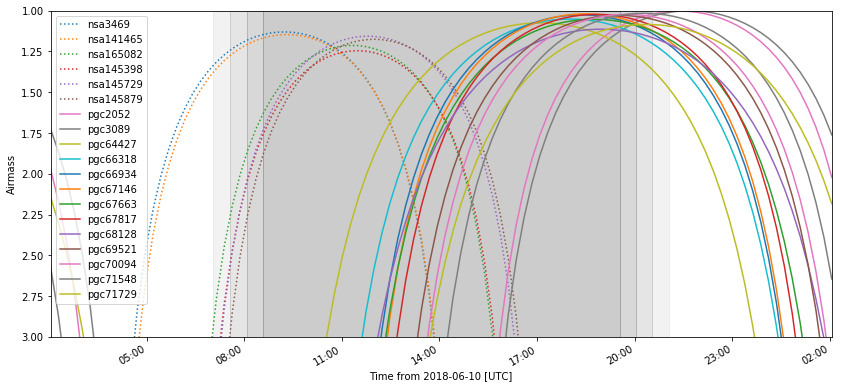

In [171]:
plt.figure(figsize=(14, 6))
astroplan.plots.plot_airmass(nsatargs, aatobs, run_start,
                             style_kwargs=dict(linestyle=':'))
astroplan.plots.plot_airmass(destargs, aatobs, run_start, 
                             style_kwargs=dict(linestyle='-'),
                             brightness_shading=True)
plt.legend(loc=0)

In [76]:
{host['ID_STR']:host['coord'].to_string('hmsdms') for host in targethosts}

{'nsa141465': '12h28m50.64s -01d56m21.048s',
 'nsa145398': '14h39m11.04s +05d21m48.492s',
 'nsa145729': '14h58m22.56s -01d05m27.672s',
 'nsa145879': '15h09m49.44s +00d28m12.306s',
 'nsa165082': '14h29m40.32s +03d13m59.916s',
 'nsa3469': '12h23m54s -03d26m34.548s',
 'pgc2052': '00h34m15.492s -27d48m13.32s',
 'pgc3089': '00h52m42.36s -31d12m20.88s',
 'pgc64427': '20h17m17.28s -52d47m48.48s',
 'pgc66318': '21h11m52.08s -49d17m01.68s',
 'pgc66934': '21h32m35.28s -44d04m03.36s',
 'pgc67146': '21h40m12.96s -42d32m21.84s',
 'pgc67663': '21h56m09.6s -49d31m19.2s',
 'pgc67817': '22h00m32.88s -43d23m23.28s',
 'pgc68128': '22h08m34.32s -57d26m33.36s',
 'pgc69521': '22h41m52.32s -44d46m02.28s',
 'pgc70094': '22h57m13.44s -43d23m45.96s',
 'pgc71548': '23h28m43.44s -41d20m00.24s',
 'pgc71729': '23h33m16.8s -54d05m40.2s'}

# Tests/Experiments 

## Compare Gaia to SDSS guide stars 

First need to get the Gaia catalog for an NSA object

In [240]:
from astroquery.gaia import Gaia

host = targethosts[targethosts['NSAID']==145729][0]
hostname = host['ID_STR']

fn = 'external_catalogs/astrometric/{}_gaia.ecsv'.format(hostname)
if os.path.exists(fn):
    print('File', fn, 'exists, skipping.')
else:
    gaiajob = Gaia.cone_search_async(host['coord'], radius=1*u.deg)
    gaia_tab = gaiajob.get_data()
    gaia_tab.write(fn, format='ascii.ecsv')

File external_catalogs/astrometric/nsa145729_gaia.ecsv exists, skipping.


In [186]:
sg = get_sdss_guidestars(hostname)
gg = get_gaia_guidestars(hostname)

Object catalog to Gaia offset: (<Angle 0.08164132 arcsec>, <Angle 0.07912354 arcsec>)


/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [244]:
targeting.sampled_imagelist(gg['RA'], gg['Dec'])

'name ra dec\n0 224.5906678370427 -1.2950137489728544\n1 225.474151384421 -1.0878728139581342\n2 223.72076787853638 -1.064198175815504\n3 224.69971909393655 -0.11598412583400089\n4 224.49166343911241 -0.24257767434462332\n5 224.62463741931958 -0.4230975491424615\n6 224.37369153842926 -0.4800222383547373\n7 224.19404148678638 -0.8220071323707093\n8 224.65252782545224 -1.0847146863650194\n9 224.1410110620503 -0.2071167177698061\n10 224.9363866472278 -1.4903310568051382\n11 224.67017945756132 -1.7733027482083552\n12 225.40836029262869 -1.400029760022471\n13 225.30634144468124 -0.7161621971578055\n14 224.83571123330182 -1.322937187697389\n15 224.0925068883515 -0.9660130396193417\n16 224.23739191824615 -0.8706479440961696\n17 224.8091204040939 -1.3722094648864824\n18 223.82874853027943 -1.6120410701977648\n19 224.77117744444803 -1.5807623766054963\n20 225.35423764341257 -0.5469297014793553\n21 224.60782395831689 -0.47159126202074086\n22 224.3219072547881 -0.5827964838166261\n23 225.31209348

They all look like reasonable guide stars...

In [190]:
gg = get_gaia_guidestars(hostname)

Object catalog to Gaia offset: (<Angle 0.08164132 arcsec>, <Angle 0.07912354 arcsec>)


/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [191]:
gstarcat = gg.meta['gstarcat']
gsc = SkyCoord(gstarcat['ra'], gstarcat['dec'])
obj_cat = saga_object_catalog.load(hostname)[0]
sstarcat = obj_cat[np.in1d(obj_cat['OBJID'], sg['TargetName'])]

(-0.3, 0.3)

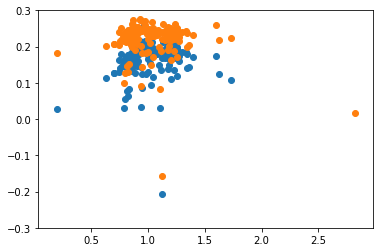

In [192]:
idx, d2d, _ = gsc.match_to_catalog_sky(sstarcat['coord'])
gcatmsk = gstarcat[d2d < 1*u.arcsec]
scatmsk = sstarcat[idx[d2d < 1*u.arcsec]]
ggmsk = gg[d2d<1*u.arcsec]

plt.scatter(gcatmsk['bp_rp'], gcatmsk['phot_g_mean_mag'] - scatmsk['r_mag'])
plt.scatter(gcatmsk['bp_rp'], ggmsk['Magnitude'] - scatmsk['r_mag'])
plt.ylim(-.3, .3)

That is strange.  Evans et al. 2018 would imply this should be ~ -0.1, not 0.2 to 0.3 ... unless this is a magnitude/SED effect?

In [194]:
gall = table.Table.read('external_catalogs/astrometric/nsa145729_gaia.ecsv')

/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


Text(0,0.5,'$G_-r$')

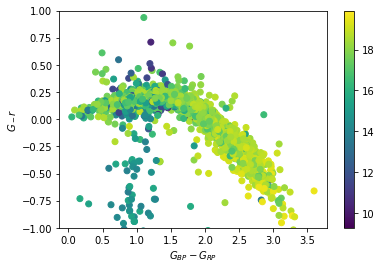

In [229]:
gmag = gall['phot_g_mean_mag']
gcut = gall[(gmag < 19)]
star_obj_cat = obj_cat[~obj_cat['is_galaxy']&(obj_cat['r_mag']>-9998)&(obj_cat['r_mag']<21)]
gsc = SkyCoord(gcut['ra'], gcut['dec'])
idx, d2d, _ = gsc.match_to_catalog_sky(star_obj_cat['coord'])

g_matches = gcut[d2d< 1*u.arcsec]
star_matches = star_obj_cat[idx[d2d< 1*u.arcsec]]

plt.scatter(g_matches['bp_rp'], g_matches['phot_g_mean_mag'] - star_matches['r_mag'], c=star_matches['r_mag'])
plt.ylim(-1, 1)
plt.colorbar()
plt.xlabel('$G_{BP}-G_{RP}$')
plt.ylabel('$G_-r$')

... is extinction included in these r-mags?

In [241]:
host['A_r']

0.132215

Nope that's still not it...?

## Initial testing of AAT guide star code 

In [16]:
# for host in targethosts:
#     hostname = host[host_id_label]
#     print(hostname)
#     tcat = saga_targets.build_target_catalogs(hostname, return_as='list').pop()
#     acat = saga.targets.prepare_aat_catalog(tcat)
#     #acat = saga.targets.prepare_aat_catalog(tcat, 'aat_targets_jun2018/{}.cat'.format(hostname))
#     break

In [18]:
# hostname = targethosts[0][host_id_label]
# fnout = 'aat_targets_jun2018/{}.fld'.format(hostname)
# print(fnout)
# guidestars = get_sdss_guidestars(hostname)
# writecat = table.vstack([acat, guidestars])
# writecat['Notes'] = [n.title() for n in writecat['Notes']]
# write_fld_file(writecat, targethosts[0], obs_start_date, fnout)

In [245]:
# reload(aat)
# aat.subsample_from_master_fld('aat_targets_jun2018/pgc2052.fld', 
#                               'aat_targets_jun2018/test_sub.fld',
#                              {1:np.inf,2:np.inf,3:np.inf,4:np.inf,
#                               5:np.inf,6:np.inf,7:np.inf,8:0,9:0})

Does not work b/c the names are different

In [16]:
#tab = saga_object_catalog.load('pgc2052')[0]

In [26]:
#sdss_guidestars = tab[(12.5<tab['r_mag'])&(tab['r_mag']<14)&(~tab['is_galaxy'])]